In [99]:
import os, prody
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

self_dir = os.getcwd()
root_dir = os.path.normpath(self_dir + '/..' * 2)

af2_dir = '/mnt/hdd/yenlin/data/AlphaFoldDB/pdb'

coupling_types = ['codir', 'coord', 'deform']
edge_types = ['contact'] + coupling_types


In [2]:
save = True

plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

et_color = {
    'contact': (0., 0.6039215686274509, 0.8705882352941177),
    'codir': (0., 0.803921568627451, 0.4235294117647059),
    'coord': (0.6862745098039216, 0.34509803921568627, 0.7294117647058823),
    'deform': (1., 0.7764705882352941, 0.11764705882352941),
}

labels = {
    et: f'{et} coupling' if et != 'contact' else 'distance (Å)'
    for et in edge_types
}

chain_color = {
    '0A': [0,0,255,255],
    '0B': [255,0,0,255],
    '0C': [0,255,255,255],
}

residue_color = {
    'ASP': [230,10,10,255],
    'GLU': [230,10,10,255],
    'CYS': [230,230,0,255],
    'MET': [230,230,0,255],
    'LYS': [20,90,255,255],
    'ARG': [20,90,255,255],
    'SER': [250,150,0,255],
    'THR': [250,150,0,255],
    'PHE': [50,50,170,255],
    'TYR': [50,50,170,255],
    'ASN': [0,220,220,255],
    'GLN': [0,220,220,255],
    'GLY': [235,235,235,255],
    'LEU': [15,130,15,255],
    'VAL': [15,130,15,255],
    'ILE': [15,130,15,255],
    'ALA': [200,200,200,255],
    'TRP': [180,90,180,255],
    'HIS': [130,130,210,255],
    # 'HSE': [130,130,210,255],
    'PRO': [220,150,130,255],
}

res3_to_res1 = {
    'CYS': 'C',
    'ASP': 'D',
    'SER': 'S',
    'GLN': 'Q',
    'LYS': 'K',
    'ILE': 'I',
    'PRO': 'P',
    'THR': 'T',
    'PHE': 'F',
    'ASN': 'N',
    'GLY': 'G',
    'HIS': 'H',
    #  'HSE': 'H',
    'LEU': 'L',
    'ARG': 'R',
    'TRP': 'W',
    'ALA': 'A',
    'VAL': 'V',
    'GLU': 'E',
    'TYR': 'Y',
    'MET': 'M',
}


In [46]:

accessions_to_plot = [
    f'{acc}-AFv4' for acc in [

        'P02309', # greatest abs improvement (base 1 vs dyn 4)
        'P0AG51', # greatest abs improvement (base 1 vs dyn 4)
        'P29018', # greatest abs improvement (base 1 vs dyn 4)
        'P42923', # greatest abs improvement (base 1 vs dyn 4)
        'Q6KYX4', # greatest abs improvement (base 1 vs dyn 4)
        'Q6KZ82', # greatest abs improvement (base 1 vs dyn 4)
        'Q9SR37', # greatest abs improvement (base 1 vs dyn 4)
        'D3YVZ9', # greatest abs improvement (base 1 vs dyn 4)
        'Q6L1A1', # greatest abs improvement (base 1 vs dyn 4)
        'P0AAR3', # greatest abs improvement (base 1 vs dyn 4)
        'Q72KZ7', # greatest abs improvement (base 1 vs dyn 4)
        'P36049', # greatest abs improvement (base 1 vs dyn 4)
        'Q08969', # greatest abs improvement (base 1 vs dyn 4)
        'P13663', # greatest abs improvement (base 1 vs dyn 4)
        'Q72GX4', # greatest abs improvement (base 1 vs dyn 4)
        'Q72JU4', # greatest abs improvement (base 1 vs dyn 4)
        'P0A9N0', # greatest abs improvement (base 1 vs dyn 4)
        'Q72K10', # greatest abs improvement (base 1 vs dyn 4)
        'Q6L177', # greatest abs improvement (base 1 vs dyn 4)
        'Q6L2J8', # greatest abs improvement (base 1 vs dyn 4)
        'Q9UN37', # greatest abs improvement (base 1 vs dyn 4)

    ]
]

meta_test = np.loadtxt(
    f'{root_dir}/experiments/DeepSTABp-lysate (short)/script - build folds/metadata - DeepSTABp-lysate (processable) - test.csv',
    delimiter=',',
    dtype=np.str_
)

accessions = meta_test[:,0]
accessions_mod = [f'{acc}-AFv4' for acc in accessions]
print(len(accessions_mod))
print(accessions_mod[:5])

OGTs = meta_test[:,2].astype(np.int16)
print(OGTs.shape)
print(OGTs[:5])

acc2ogt = {
    acc: int(ogt) for acc, ogt in zip(accessions_mod, OGTs)
}

ogt_of_accessions_to_plot = np.array([
    acc2ogt[acc] for acc in accessions_to_plot
])
print(ogt_of_accessions_to_plot)


2044
['A0A023PXQ4-AFv4', 'A0A061ACI3-AFv4', 'A0A061ACL3-AFv4', 'A0A061ACL6-AFv4', 'A0A061ACX4-AFv4']
(2044,)
[32 20 20 20 20]
[32 37 37 37 60 60 22 37 60 37 70 32 32 32 70 70 37 70 60 60 37]


In [24]:

all_counts = {
    'seq_len': [],
    'edges': [],
}
impr_counts = {
    'seq_len': [],
    'edges': [],
}

for accession in tqdm(accessions_mod, ascii=True):

    pdb_file = f'{af2_dir}/{accession}.pdb'

    atoms = prody.parsePDB(
        pdb_file,
        subset='ca'
    )

    seq_len = len(atoms.select('name CA'))
    all_counts['seq_len'].append(seq_len)

    dist_matrix = prody.buildDistMatrix(atoms)
    dist_vector = dist_matrix[np.triu_indices(seq_len, k=1)]

    edge_counts = len(dist_vector[dist_vector < 12.0])
    all_counts['edges'].append(edge_counts)

    if accession in accessions_to_plot:
        impr_counts['seq_len'].append(seq_len)
        impr_counts['edges'].append(edge_counts)


100%|##########| 2044/2044 [00:31<00:00, 65.17it/s] 


In [87]:
max(all_counts['edges'])

14201

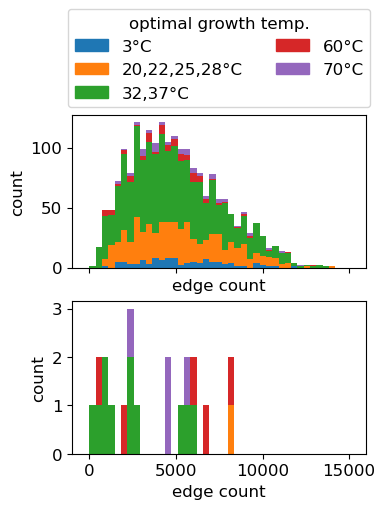

In [106]:
#

bins = np.linspace(0, max(all_counts['edges']), 40)

ogt_groups = (
    3,
    (20, 30),
    (30, 40),
    60,
    70
)

fig, axes = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(7.48/2, 7.48/2/1157*1541),
    layout='constrained'
)

labels = []
for grp_idx, ogt_group in enumerate(ogt_groups[::-1]):

    if isinstance(ogt_group, tuple):
        ogt_min, ogt_max = ogt_group
        loc_all = OGTs <= ogt_max
        loc_best = ogt_of_accessions_to_plot <= ogt_max

        ogt_str = ",".join(np.unique(
            OGTs[
                np.bitwise_and(
                        OGTs >= ogt_min,
                        OGTs < ogt_max
                    )
                ]
        ).astype(np.str_))
        labels.append(f'{ogt_str}°C')
    else:
        ogt_val = ogt_group
        loc_all = OGTs <= ogt_val
        loc_best = ogt_of_accessions_to_plot <= ogt_val
        labels.append(f'{ogt_val:.0f}°C')

    values = np.array(all_counts['edges'])[loc_all]

    axes[0].hist(
        values,
        bins=bins,
        color=f'C{len(ogt_groups)-grp_idx-1}'
    )

    axes[0].set_xlabel('edge count', fontsize=12)
    axes[0].set_ylabel('count', fontsize=12)

    # ## MARK IMPROVED PROTEINS
    # for grp_idx, ogt_group in enumerate(ogt_groups):
    #     if isinstance(ogt_group, tuple):
    #         ogt_min, ogt_max = ogt_group
    #         loc = np.bitwise_and(
    #             ogt_of_accessions_to_plot >= ogt_min,
    #             ogt_of_accessions_to_plot < ogt_max
    #         )
    #         if np.sum(loc) > 0:
    #             vals = np.array(impr_counts['edges'])[loc]
    #             for v in vals:
    #                 axes[0].axvline(
    #                     v,
    #                     color=f'C{grp_idx}',
    #                     # linestyle='--',
    #                     # alpha=0.3,
    #                     linewidth=1
    #                 )
    #     else:
    #         ogt_val = ogt_group
    #         loc = ogt_of_accessions_to_plot == ogt_val
    #         if np.sum(loc) > 0:
    #             vals = np.array(impr_counts['edges'])[loc]
    #             for v in vals:
    #                 axes[0].axvline(
    #                     v,
    #                     color=f'C{grp_idx}',
    #                     # linestyle='--',
    #                     # alpha=0.3,
    #                     linewidth=1
    #                 )

    if loc_best.sum() != 0:
        axes[1].hist(
            np.array(impr_counts['edges'])[loc_best],
            bins=bins,
            color=f'C{len(ogt_groups)-grp_idx-1}'
        )

    axes[1].set_xlabel('edge count', fontsize=12)
    axes[1].set_ylabel('count', fontsize=12)

    axes[1].set_yticks(np.arange(4))

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xticks(np.arange(0, 15001, 5000))
    ax.set_xlim(-1000, 16000)

patches = [
    mpatches.Patch(
        label=labels[len(labels)-idx-1],
        # facecolor='white',
        # edgecolor='black',
        color=f'C{idx}',
        # hatch=setup_hatch[setup],
    )
    for idx in range(len(ogt_groups))
]
axes[0].legend(
    handles=patches,
    loc='upper center',
    title='optimal growth temp.',
    title_fontsize=12,
    fontsize=12,
    bbox_to_anchor=(0.5, 1.75),
    ncol=2,
)

plt.savefig(
    f'{plots_dir}/edge count distribution.png',
    dpi=300,
    bbox_inches='tight',
)
plt.show()
plt.close()
